# Initial Data Exploration
This notebook contains initial data exploration and analysis.

In [20]:
import os

# Print current working directory
print("Current directory:", os.getcwd())

# List all files in current directory
print("\nFiles in directory:")
print(os.listdir())

Current directory: /Users/karthiknadella/Documents/Data Stories/youtube/notebooks

Files in directory:
['.DS_Store', '01_initial_data_exploration.ipynb', 'watch-history.json', 'enriched_youtube_history.csv']


In [21]:
import pandas as pd
import json

def parse_youtube_history(json_file):
    # Read the JSON file
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # If the data is a list of records
    if isinstance(data, list):
        records = data
    else:
        # If it's a single record, wrap it in a list
        records = [data]
    
    # Process each record to flatten the data
    processed_records = []
    for record in records:
        processed_record = {
            'header': record.get('header'),
            'title': record.get('title'),
            'title_url': record.get('titleUrl'),
            'channel_name': record['subtitles'][0]['name'] if record.get('subtitles') else None,
            'channel_url': record['subtitles'][0]['url'] if record.get('subtitles') else None,
            'timestamp': pd.to_datetime(record.get('time')),
            'products': ', '.join(record.get('products', [])),
            'activity_controls': ', '.join(record.get('activityControls', []))
        }
        processed_records.append(processed_record)
    
    # Create DataFrame
    df = pd.DataFrame(processed_records)
    return df

# Usage example
if __name__ == "__main__":
    # Replace 'your_file.json' with your actual JSON file path
    file_path = 'watch-history.json'
    try:
        df = parse_youtube_history(file_path)
        print("DataFrame created successfully!")
        print("\nDataFrame Info:")
        print(df.info())
        print("\nFirst few rows:")
        print(df.head())
    except Exception as e:
        print(f"An error occurred: {str(e)}")

DataFrame created successfully!

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5867 entries, 0 to 5866
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   header             5867 non-null   object             
 1   title              5867 non-null   object             
 2   title_url          5867 non-null   object             
 3   channel_name       5781 non-null   object             
 4   channel_url        5781 non-null   object             
 5   timestamp          5867 non-null   datetime64[ns, UTC]
 6   products           5867 non-null   object             
 7   activity_controls  5867 non-null   object             
dtypes: datetime64[ns, UTC](1), object(7)
memory usage: 366.8+ KB
None

First few rows:
    header                                              title  \
0  YouTube  Watched Taylor Swift and Travis Kelce partying...   
1  YouTube     Watched That

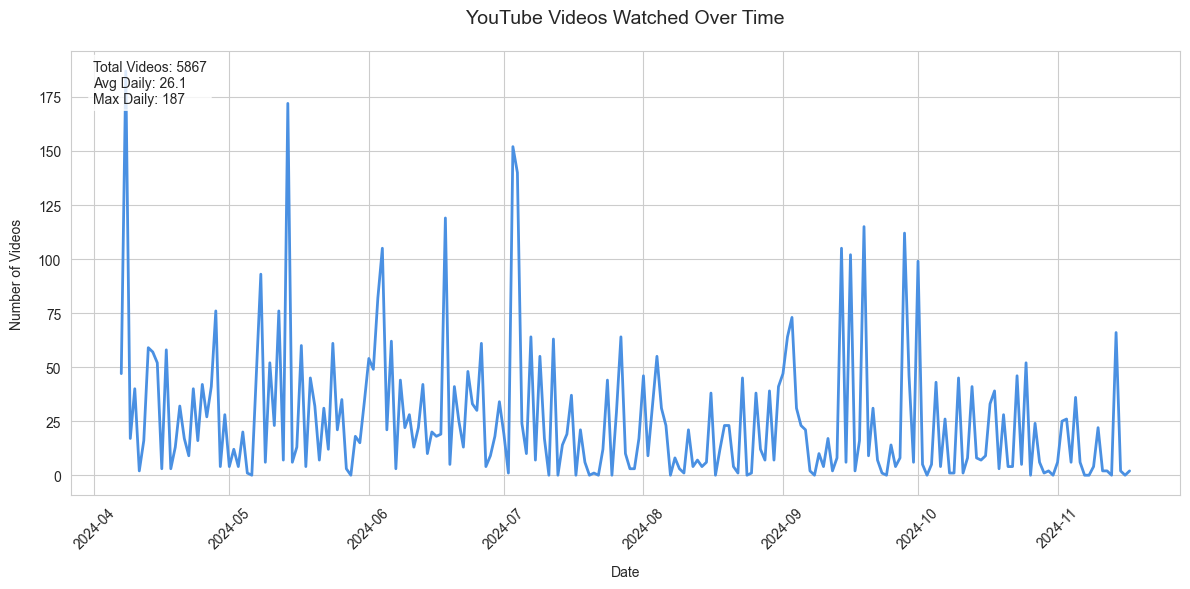

In [22]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

def create_youtube_timeseries(json_file):
    # Read and parse the JSON file
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # Ensure data is a list
    records = data if isinstance(data, list) else [data]
    
    # Create DataFrame
    df = pd.DataFrame(records)
    
    # Convert time to datetime
    df['time'] = pd.to_datetime(df['time'])
    
    # Set time as index and resample by day to get daily counts
    daily_counts = df.set_index('time').resample('D').size().reset_index()
    daily_counts.columns = ['date', 'video_count']
    
    # Create the visualization
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    # Plot the data
    plt.plot(daily_counts['date'], daily_counts['video_count'], 
             color='#4A90E2', linewidth=2)
    
    # Customize the plot
    plt.title('YouTube Videos Watched Over Time', pad=20, size=14)
    plt.xlabel('Date', labelpad=10)
    plt.ylabel('Number of Videos', labelpad=10)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Add some statistics as text
    total_videos = daily_counts['video_count'].sum()
    avg_daily = daily_counts['video_count'].mean()
    max_daily = daily_counts['video_count'].max()
    
    stats_text = f'Total Videos: {int(total_videos)}\n'
    stats_text += f'Avg Daily: {avg_daily:.1f}\n'
    stats_text += f'Max Daily: {int(max_daily)}'
    
    plt.text(0.02, 0.98, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    return plt

# Usage example
if __name__ == "__main__":
    # Replace with your JSON file path
    file_path = 'watch-history.json'
    try:
        plt = create_youtube_timeseries(file_path)
        plt.show()
        
        # Optionally save the plot
        # plt.savefig('youtube_history_plot.png', dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"An error occurred: {str(e)}")

In [26]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Get API key from environment
api_key = os.getenv('YOUTUBE_API_KEY')
if not api_key:
    raise ValueError("Missing YOUTUBE_API_KEY environment variable")

def extract_video_id(url):
    """Extract video ID from YouTube URL"""
    if not url:
        return None
        
    # Handle escaped unicode format (\u003d)
    if 'u003d' in url:
        return url.split('u003d')[-1]
    # Handle standard format (v=)
    elif 'v=' in url:
        return url.split('v=')[-1].split('&')[0]
    # Handle /watch/ format
    elif '/watch/' in url:
        return url.split('/watch/')[-1]
    return None

def get_video_details_batch(video_ids, api_key, batch_size=50):
    """Get details for multiple videos in one API call"""
    url = "https://www.googleapis.com/youtube/v3/videos"
    
    # Convert video_ids to list if it's not already
    video_ids = list(video_ids)
    results = {}
    
    # Process in batches of batch_size
    for i in range(0, len(video_ids), batch_size):
        batch = video_ids[i:i + batch_size]
        
        params = {
            "part": "contentDetails,topicDetails,snippet",
            "id": ",".join(batch),  # Join IDs with commas
            "key": api_key
        }
        
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()
            data = response.json()
            
            # Process each video in the response
            for item in data.get('items', []):
                video_id = item['id']
                
                # Get duration
                duration_iso = item['contentDetails']['duration']
                duration_seconds = int(isodate.parse_duration(duration_iso).total_seconds())
                
                # Get topics
                topic_details = item.get('topicDetails', {})
                categories = [cat.split('/')[-1].replace('_', ' ') 
                            for cat in topic_details.get('topicCategories', [])]
                
                results[video_id] = {
                    'duration_seconds': duration_seconds,
                    'topic_categories': categories
                }
            
            # Add a small delay between batches
            time.sleep(0.1)
            
        except Exception as e:
            print(f"Error processing batch: {str(e)}")
            continue
            
    return results

def enrich_youtube_history(json_file, api_key):
    # First parse the basic history
    df = parse_youtube_history(json_file)
    
    # Extract video IDs from title_url
    df['video_id'] = df['title_url'].apply(extract_video_id)
    
    # Get unique, non-null video IDs
    video_ids = df['video_id'].dropna().unique()
    
    print(f"Processing {len(video_ids)} unique videos...")
    
    # Get details for all videos
    video_details = get_video_details_batch(video_ids, api_key)
    
    # Add the details back to the dataframe
    df['duration_seconds'] = df['video_id'].map(
        lambda x: video_details.get(x, {}).get('duration_seconds'))
    df['topic_categories'] = df['video_id'].map(
        lambda x: video_details.get(x, {}).get('topic_categories'))
    
    return df

# Usage example
if __name__ == "__main__":
    import time
    from tqdm import tqdm
    
    file_path = 'watch-history.json'
  
    
    try:
        df = enrich_youtube_history(file_path, api_key)
        
        # Display some statistics
        print("\nData Summary:")
        print(f"Total videos processed: {len(df)}")
        print(f"Videos with duration data: {df['duration_seconds'].notna().sum()}")
        print(f"Videos with topic data: {df['topic_categories'].notna().sum()}")
        
        # Save enriched data
        df.to_csv('enriched_youtube_history.csv', index=False)
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")

Processing 5706 unique videos...


KeyboardInterrupt: 

Dataset Overview:
Total records: 5867
Date range: 2024-04-07 03:20:58.113000+00:00 to 2024-11-17 21:43:04.210000+00:00

Columns in dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5867 entries, 0 to 5866
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   header             5867 non-null   object             
 1   title              5867 non-null   object             
 2   title_url          5867 non-null   object             
 3   channel_name       5781 non-null   object             
 4   channel_url        5781 non-null   object             
 5   timestamp          5867 non-null   datetime64[ns, UTC]
 6   products           5867 non-null   object             
 7   activity_controls  5867 non-null   object             
 8   video_id           5867 non-null   object             
 9   duration_seconds   5780 non-null   float64            
 10  topic_categories   5780 non-

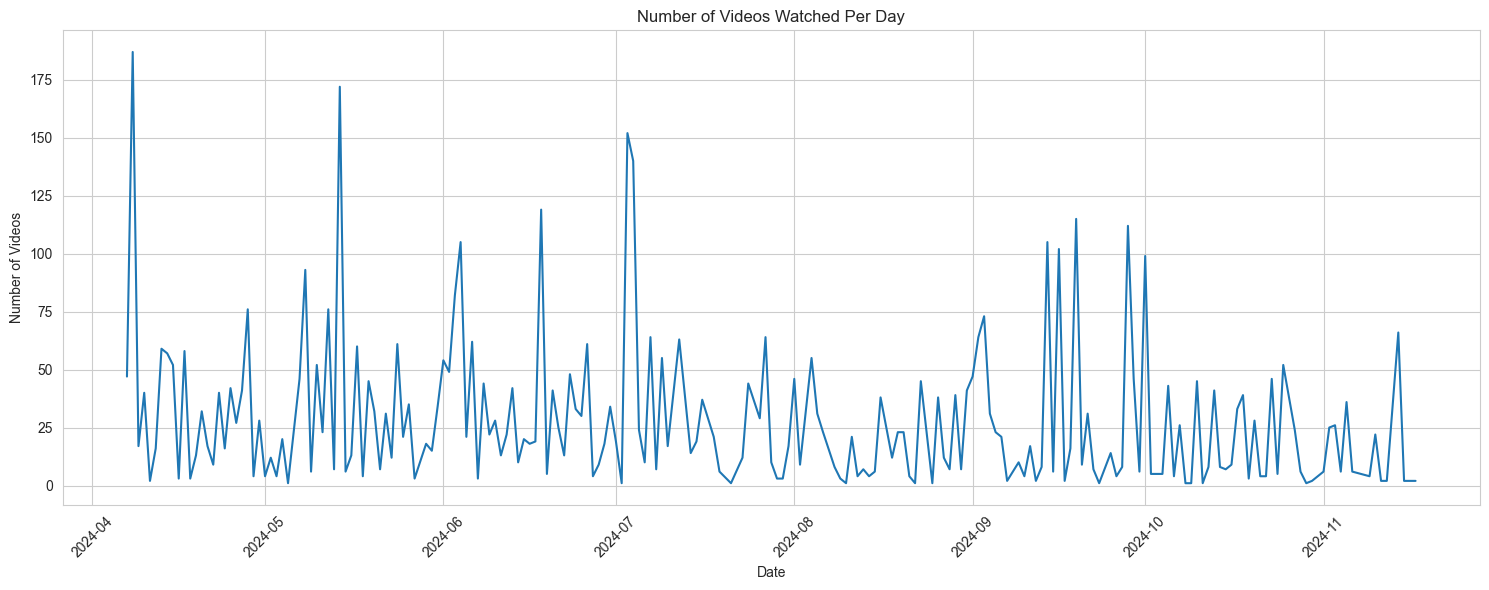

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Read the CSV file
df = pd.read_csv('enriched_youtube_history.csv')

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Basic info about the dataset
print("Dataset Overview:")
print(f"Total records: {len(df)}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nColumns in dataset:")
print(df.info())

# Quick statistics about video durations
print("\nVideo Duration Statistics (in minutes):")
print(df['duration_seconds'].describe() / 60)

# Most common topics
print("\nMost Common Topics:")
# Explode the topic_categories list into separate rows
topic_counts = df.explode('topic_categories')['topic_categories'].value_counts().head(10)
print(topic_counts)

# Example visualization: Videos watched per day
daily_counts = df.groupby(df['timestamp'].dt.date).size()
plt.figure(figsize=(15, 6))
daily_counts.plot(kind='line')
plt.title('Number of Videos Watched Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Videos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/Users/karthiknadella/Documents/Data Stories/youtube/venv/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/var/folders/d3/4lb_fx_x04d3nvwbz2_6sjlm0000gn/T/ipykernel_47691/3241390405.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1500x800 with 0 Axes>

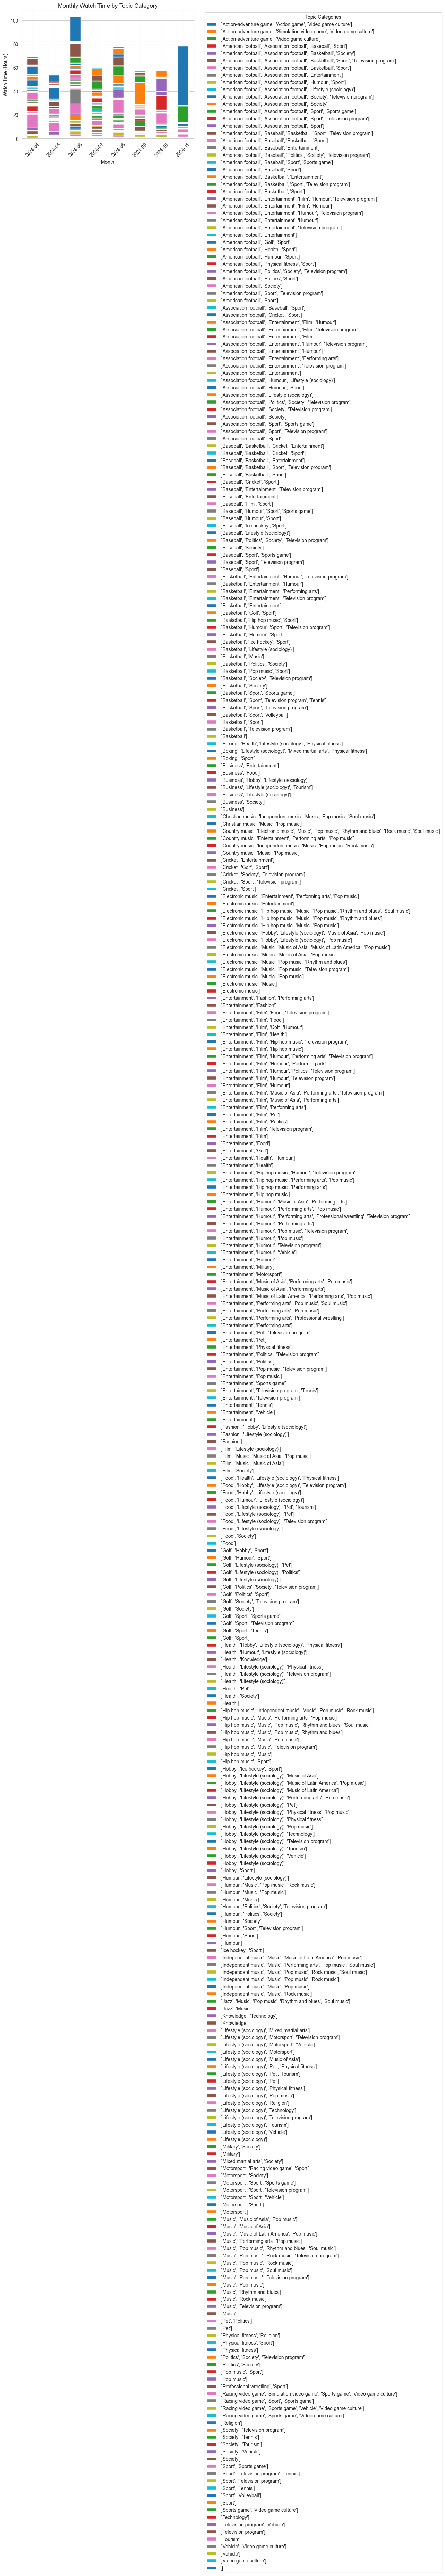


Total Hours per Category:
topic_categories
[]                                                                    80.67
['Health', 'Lifestyle (sociology)', 'Physical fitness']               42.51
['Politics', 'Society']                                               38.90
['Basketball', 'Sport']                                               38.42
['Politics', 'Society', 'Television program']                         33.42
                                                                      ...  
['Entertainment', 'Hip hop music', 'Humour', 'Television program']     0.00
['Lifestyle (sociology)', 'Music of Asia']                             0.00
['Baseball', 'Humour', 'Sport']                                        0.00
['Hobby', 'Lifestyle (sociology)', 'Music of Latin America']           0.00
['Baseball', 'Lifestyle (sociology)']                                  0.00
Name: duration_hours, Length: 351, dtype: float64


In [27]:
# Prepare the data
# Read the CSV file
df = pd.read_csv('enriched_youtube_history.csv')

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Convert timestamp to month and duration to hours
df['month'] = df['timestamp'].dt.to_period('M')
df['duration_hours'] = df['duration_seconds'] / 3600

# Group by month and category, sum the duration
monthly_by_category = df.pivot_table(
    index='month',
    columns='topic_categories',
    values='duration_hours',
    aggfunc='sum'
).fillna(0)

# Create the stacked bar chart
plt.figure(figsize=(15, 8))
monthly_by_category.plot(kind='bar', stacked=True)

plt.title('Monthly Watch Time by Topic Category')
plt.xlabel('Month')
plt.ylabel('Watch Time (Hours)')
plt.legend(title='Topic Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print total hours per category
print("\nTotal Hours per Category:")
category_totals = df.groupby('topic_categories')['duration_hours'].sum().sort_values(ascending=False)
print(category_totals.round(2))

/Users/karthiknadella/Documents/Data Stories/youtube/venv/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/var/folders/d3/4lb_fx_x04d3nvwbz2_6sjlm0000gn/T/ipykernel_47691/3515032353.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1500x800 with 0 Axes>

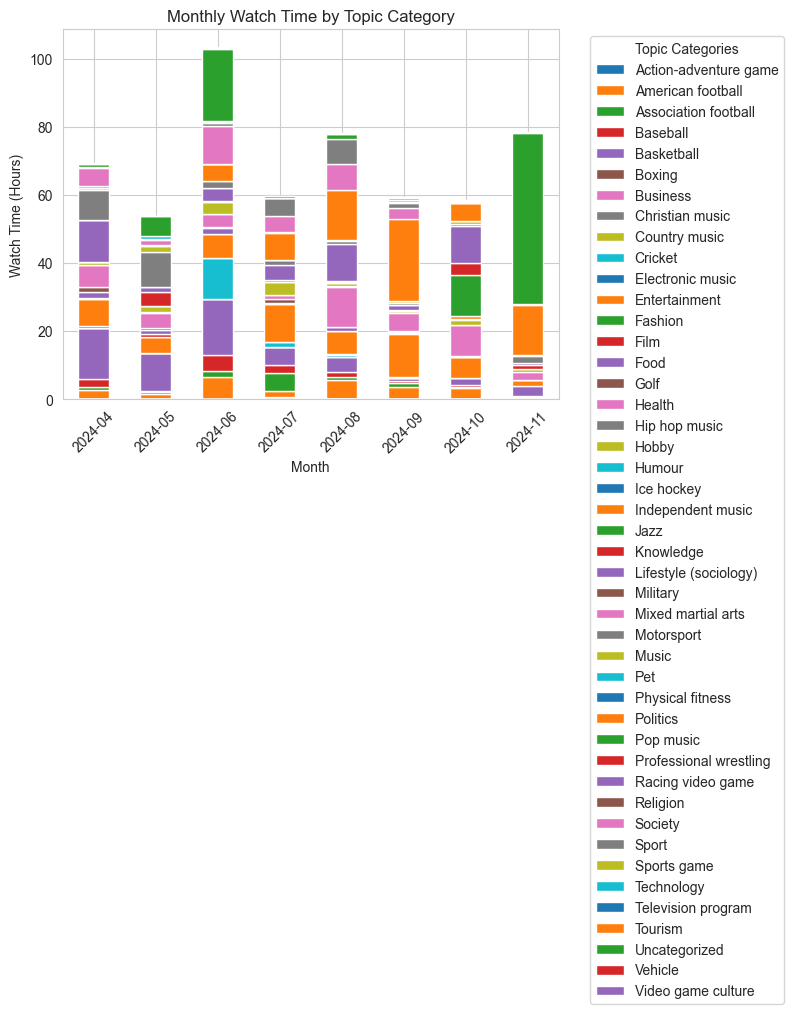


Total Hours per Category:
main_category
Uncategorized             80.67
Politics                  72.32
Entertainment             57.95
Basketball                57.22
Lifestyle (sociology)     46.43
Health                    44.51
Society                   33.89
Motorsport                26.23
American football         25.44
Sport                     15.98
Cricket                   14.32
Hobby                     13.60
Baseball                  13.03
Jazz                      11.95
Association football      10.60
Knowledge                  9.04
Food                       7.22
Music                      4.36
Golf                       3.84
Technology                 1.68
Video game culture         1.51
Independent music          1.35
Vehicle                    1.12
Electronic music           1.10
Film                       0.94
Ice hockey                 0.74
Action-adventure game      0.71
Hip hop music              0.59
Humour                     0.48
Physical fitness           0.47

In [28]:
# Convert timestamp to month and duration to hours
df['month'] = df['timestamp'].dt.to_period('M')
df['duration_hours'] = df['duration_seconds'] / 3600

# Extract first category
def get_first_category(categories_str):
    try:
        # Convert string to list using literal_eval and get first item
        categories = ast.literal_eval(categories_str)
        return categories[0] if categories else 'Uncategorized'
    except:
        return 'Uncategorized'

# Create new column with just the first category
df['main_category'] = df['topic_categories'].apply(get_first_category)

# Create the stacked bar chart
plt.figure(figsize=(15, 8))
monthly_by_category = df.pivot_table(
    index='month',
    columns='main_category',
    values='duration_hours',
    aggfunc='sum'
).fillna(0)

monthly_by_category.plot(kind='bar', stacked=True)
plt.title('Monthly Watch Time by Topic Category')
plt.xlabel('Month')
plt.ylabel('Watch Time (Hours)')
plt.legend(title='Topic Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print total hours per category
print("\nTotal Hours per Category:")
category_totals = df.groupby('main_category')['duration_hours'].sum().sort_values(ascending=False)
print(category_totals.round(2))

In [30]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Prepare the data at different levels
def get_category_at_level(categories_str, level=0):
    try:
        categories = ast.literal_eval(categories_str)
        return categories[level] if len(categories) > level else 'Uncategorized'
    except:
        return 'Uncategorized'

# Create columns for different category levels
df['category_l1'] = df['topic_categories'].apply(lambda x: get_category_at_level(x, 0))
df['category_l2'] = df['topic_categories'].apply(lambda x: get_category_at_level(x, 1))

# Create the interactive visualization
fig = px.bar(df, 
             x='month',
             y='duration_hours',
             color='category_l1',
             title='Monthly Watch Time by Category',
             labels={'duration_hours': 'Watch Time (Hours)',
                    'month': 'Month',
                    'category_l1': 'Category'},
             height=600)

# Update layout
fig.update_layout(barmode='stack',
                 xaxis_tickangle=45,
                 showlegend=True,
                 hovermode='x unified')

# Show the plot
fig.show()

TypeError: Object of type Period is not JSON serializable

In [31]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Convert timestamp to datetime (not Period)
df['month'] = df['timestamp'].dt.strftime('%Y-%m')  # This will be string format 'YYYY-MM'
df['duration_hours'] = df['duration_seconds'] / 3600

# Extract first category
def get_category_at_level(categories_str, level=0):
    try:
        categories = ast.literal_eval(categories_str)
        return categories[level] if len(categories) > level else 'Uncategorized'
    except:
        return 'Uncategorized'

# Create columns for different category levels
df['category_l1'] = df['topic_categories'].apply(lambda x: get_category_at_level(x, 0))
df['category_l2'] = df['topic_categories'].apply(lambda x: get_category_at_level(x, 1))

# Create the interactive visualization
fig = px.bar(df, 
             x='month',
             y='duration_hours',
             color='category_l1',
             title='Monthly Watch Time by Category',
             labels={'duration_hours': 'Watch Time (Hours)',
                    'month': 'Month',
                    'category_l1': 'Category'},
             height=600)

# Update layout
fig.update_layout(barmode='stack',
                 xaxis_tickangle=45,
                 showlegend=True,
                 hovermode='x unified')

# Show the plot
fig.show()

In [ ]:
# Let's examine what we're working with
print("Topic categories data type:", df['topic_categories'].dtype)
print("\nFirst few values of topic_categories:")
print(df['topic_categories'].head())
print("\nUnique values in topic_categories:")
print(df['topic_categories'].unique()[:5])  # Just first 5 to keep output manageable